$$
\newcommand{\ped}[1]{_{\mathrm{#1}}}
\newcommand{\ap}[1]{^{\mathrm{#1}}}
\newcommand{\nvector}[1]{\mathbf{#1}}
\newcommand{\nmatrix}[1]{\mathit{#1}}
\newcommand{\unitvector}[1]{\hat{\nvector{e}}_{#1}}
\newcommand{\volume}{\mathcal{V}}
\newcommand{\average}[1]{\overline{#1}}
\newcommand{\rate}[1]{\dot{#1}}
\newcommand{\flux}[1]{{#1}''}
\newcommand{\curl}[1]{\nabla\times {#1}}
\newcommand{\curlv}[1]{\curl{\nvector{#1}}}
\newcommand{\divergent}[1]{\nabla \cdot #1}
\newcommand{\divergentv}[1]{\divergent{\nvector{#1}}}
\newcommand{\divergentpar}[1]{\divergent{\left( #1 \right)}}
\newcommand{\gradient}[1]{\nabla {#1}}
\newcommand{\gradientpar}[1]{\gradient{\left( {#1} \right)}}
\newcommand{\laplacian}[1]{\nabla^2 #1}
\newcommand{\laplacianpar}[1]{\laplacian{\left( #1 \right)}}
\newcommand{\vectornorm}[1]{\left\lVert #1 \right\rVert}
\newcommand{\diffp}[2]{\frac{\partial {#1}}{\partial {#2}}}
\newcommand{\diffps}[2]{\frac{\partial^2 {#1}}{\partial {#2}^2}}
\newcommand{\rvec}{\nvector{r}}
\newcommand{\nvh}{\nvector{H}}
\newcommand{\nvb}{\nvector{B}}
\newcommand{\nvrem}{\nvector{B}\ped{rem}}
\newcommand{\nvbrem}{\nvrem}
\newcommand{\nvm}{\nvector{M}}
\newcommand{\mur}{\mu\ped{r}}
\newcommand{\nvbremhat}{\hat{\nvector{B}}\ped{rem}}
\newcommand{\acoef}[2]{a_{{#1},\mathrm{#2}}}
\newcommand{\bcoef}[2]{b_{{#1},\mathrm{#2}}}
\newcommand{\Azexpr}[1]{A_{\mathrm{#1}\, z}}
\newcommand{\bremii}{B_{\mathrm{rem,II}}}
\newcommand{\bremiv}{B_{\mathrm{rem,IV}}}
\newcommand{\aIII}{\acoef{1}{III}}
\newcommand{\bIII}{\bcoef{1}{III}}
\newcommand{\nvbIII}{\nvector{B}\ped{III}}
\newcommand{\BIII}{B\ped{III}}
\newcommand{\diffd}[1]{\mathrm{d}\,{#1}}
$$

# TeslaMax Optimization

Teslamax model:

<img src="figures/teslamax.png" width=500>

We are intererested in finding the optimal set of remanence angles $\alpha_{\mathrm{rem},m,k}$ that will maximize some metric in the air gap.

In [1]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel



mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}',
                                      r'\usepackage{siunitx}']}
matplotlib.rcParams.update(mpl_params)

In [2]:
FIGSIZE_CM = 10
FIGSIZE_INCHES = FIGSIZE_CM / 2.54

FONTSIZE = 14



PAPER_FILE_PATH = Path('.')
FIGURES_DIR_NAME = "figures"
FIG_FILE_PATH = PAPER_FILE_PATH / Path(FIGURES_DIR_NAME)


PLOT_EXTENSION = ".png"

DPI = 2400

In [3]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [4]:
os.getcwd()

'C:\\Users\\Fabio\\code\\TeslaMax'

In [5]:
def save_figure(fig,name):
    """
    Save the 'fig' Figure object as 'name' (with extension PLOT_EXTENSION), inside FIG_FILE_PATH,
    and close the figure"""
    
    
    file_path = str(FIG_FILE_PATH / (name + PLOT_EXTENSION))
    fig.savefig(file_path,dpi=DPI,bbox_inches='tight')

## Optimization using Scipy

In [6]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.060,
                "h_gap": 0.025,
                "R_s": 0.150,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 4,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

n_II = params_optimization["n_II"]
n_IV = params_optimization["n_IV"]

n = n_II + n_IV

B_rem = 1.4

# expand parameters to include remanence magnitudes for each segment
params_optimization = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                                      params_optimization, 
                                                                      "B_rem")

alpha_B_rem_0 = np.zeros(n)


tmpd = TeslaMaxPreDesign(params_optimization)

In [7]:
%xmode verbose

target_function = teslamax.calculate_ramp_profile

B_high = 1.3
B_low = 0.0
field_fraction = 0.8
target_args = (B_high,B_low,field_fraction)

functional_args = (target_function,target_args)


objfun = tmpd.calculate_functional

bounds = [(0.0,360.0) for i in range(0,n)]

# the subscript _g in the following variable names stands for 'gradient-based' optimization methods
optres_g = minimize(objfun, 
                    alpha_B_rem_0, 
                    args=(functional_args,), 
                    bounds=bounds,
                    options={'disp': True})

Exception reporting mode: Verbose


In [8]:
alpha_B_rem_g = optres_g.x
print(alpha_B_rem_g)

[   5.58105641   22.50168062    0.            5.00549948   20.2565746
   45.32081188  100.72484641]


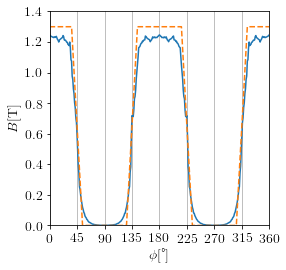

In [9]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig_g = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes_g = profile_fig_g.add_subplot(111)

teslamax_playground = str(Path.home() / "code" / "TeslaMax" / "teslamax-play" )

tmm_g = TeslaMaxModel(tmpd,
                      alpha_B_rem_g,
                      path=teslamax_playground)
tmm_g.run()
phi_vector_g, B_vector_g = tmm_g.get_profile_data().T

profile_axes_g.plot(phi_vector_g,B_vector_g)
profile_axes_g.set_xlim(0,np.max(phi_vector_g))
profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_g),9))
profile_axes_g.xaxis.grid(True)
profile_axes_g.set_ylim(0,B_high+0.1)
profile_axes_g.set_yticks(np.arange(0,B_high+0.2,0.2))
profile_axes_g.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes_g.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_ramp_profile(phi_vector_g,B_high,B_low,field_fraction)
profile_axes_g.plot(phi_vector_g,B_inst_vector,'--')

save_figure(profile_fig_g,"profile_optimized_ramp_%d" %(B_high*10))

In [10]:
teslamax.calculate_average_high_field(tmm_g.get_profile_data())

1.1208383333333334

In [11]:
tmpd.calculate_functional_gradient(alpha_B_rem_g,functional_args)

array([ -1.11155529e-06,  -2.04192219e-06,   1.52079611e-02,
        -9.28590538e-07,   3.32267547e-06,  -1.05337961e-06,
        -4.31787939e-06])

In [12]:
np.linalg.eigvals(tmpd.calculate_functional_hessian(alpha_B_rem_g,functional_args))

array([ 0.00848971,  0.00634713,  0.00489886,  0.00151966, -0.00172323,
       -0.00047435, -0.00085011])

## Optimization using evolutionary algorithms

In [ ]:
from scipy.optimize import differential_evolution, basinhopping

In [ ]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }
alpha_B_rem_0 = [15,30,45,15,45,135]

n = len(alpha_B_rem_0)

tmpd = TeslaMaxPreDesign(params_optimization)

In [ ]:
%%time 
## all this methods from the TeslaMaxPreDesign class accept as only arguments the design vector (with remanence angles)

objective_function = tmpd.calculate_functional

bounds = [(0.0, 360.0) for i in range(0,n)]

res = differential_evolution(objective_function,bounds,disp=True)

In [ ]:
res.x

In [ ]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)


teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'

tmm_optimized = TeslaMaxModel(tmpd,res.x,
                   path=teslamax_playground)
tmm_optimized.run()
phi_vector, B_vector = tmm_optimized.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector,teslamax.TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

save_figure(profile_fig,"profile_optimized_genetic_B_13")

In [ ]:
teslamax.calculate_average_high_field(tmm_optimized.get_profile_data())

In [ ]:
tmpd.calculate_functional_gradient(res.x)

In [ ]:
np.linalg.eigvals(tmpd.calculate_functional_hessian(res.x))